# Velocity & Galactic Rotation

In this notebook, you'll go through all the steps needed to go from a measured velocity to a measurement of the Galactic mass assuming circular orbits.

You just need to read along and execute cells for the first ~90%.  Then, at the end, you'll repeat what you did in the top half, but for a different target.

# Basic Python Setup

In [1]:
# preface - this is just stuff you need to run the code
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()

# if you're using a white background, comment this next line out or delete it
# ("comment out" means put a # at the start of the line)
pl.style.use('dark_background')

In [2]:
# This cell loads the moduls you need to set up an observer, target, and time

from astroplan import Observer
from astropy import units as u, coordinates
from astropy.table import Table
import datetime
import pytz
tz = pytz.timezone('US/Eastern')

In [3]:
# This cell has been "commented out" using triple-quotes

# Right now, it doesn't do anything, but it's here to show you how you would load up your own observational
# data to make a target
"""
datatable = Table.read('data/psd_200725_100309_tint60s_sdr0_fsw.fits')
obslon = float(datatable.meta['--obs_lon']) * u.deg
obslat = float(datatable.meta['--obs_lat']) * u.deg
obs_time_notz = datetime.datetime.strptime(datatable.meta['DATE-OBS'], "%y%m%d_%H%M%S")
location = coordinates.EarthLocation.from_geodetic(obslon, obslat, 100*u.m)
"""
# if you wanted to use this code, you'd remove the """'s

'\ndatatable = Table.read(\'data/psd_200725_100309_tint60s_sdr0_fsw.fits\')\nobslon = float(datatable.meta[\'--obs_lon\']) * u.deg\nobslat = float(datatable.meta[\'--obs_lat\']) * u.deg\nobs_time_notz = datetime.datetime.strptime(datatable.meta[\'DATE-OBS\'], "%y%m%d_%H%M%S")\nlocation = coordinates.EarthLocation.from_geodetic(obslon, obslat, 100*u.m)\n'

# Observer / Observation Setup

In [4]:
# instead of using the "real data" from the previous cell, we're going to make up the data
# You can't do this in the lab!  This is just to show you how the code works
gainesville_location = coordinates.EarthLocation.from_geodetic(lon=-82.3*u.deg, lat=29.6*u.deg, height=100*u.m)
observer = Observer(gainesville_location, timezone='US/Eastern')

# we're using a made-up time
obs_time_notz = datetime.datetime(year=2020, month=10, day=6, hour=20, minute=50, second=13)
obs_time = tz.localize(obs_time_notz)

# we're using a made-up pointing direction
alt = 48*u.deg
az = 220*u.deg
target_altaz = coordinates.SkyCoord(alt=alt,
                                    az=az,
                                    location=observer.location,
                                    obstime=obs_time, frame='altaz')

# we want the coordinate in both altaz and galactic
target_galactic = target_altaz.galactic

target_altaz, target_galactic

(<SkyCoord (AltAz: obstime=2020-10-07 00:50:13, location=(743674.13504562, -5500332.52750589, 3131946.80724394) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
     (220., 48.)>,
 <SkyCoord (Galactic): (l, b) in deg
     (27.85023361, -0.02209999)>)

# Radial Velocity Correction

We want to calculate the `radial_velocity_correction`, which transforms from "topocentric" (relative toour position on the surface of the Earth) to "barycentric" (relative to the center-of-mass of the solar system)

In [5]:
# our velocity in the direction of the target
target_galactic.radial_velocity_correction()

<Quantity -28357.68545983 m / s>

This is how fast we (on the surface of Earth) are moving in this direction relative to the solar system's barycenter.

In [6]:
# What direction were we looking in?
# We can check this in both RA/Dec (ICRS) and Galactic
target_galactic.icrs, target_galactic.galactic

(<SkyCoord (ICRS): (ra, dec) in deg
     (280.55719996, -4.53151752)>,
 <SkyCoord (Galactic): (l, b) in deg
     (27.85023361, -0.02209999)>)

# Velocity Measurement -> Barycentric Conversion

In the lecture, at this stage, I re-fit a spectral line.  We'll skip that now and use a made up line-of-sight velocity.

In [7]:
# this is our made-up line-of-sight velocity
# you will measure this from your data by fitting a Gaussian profile to the observed spectrum
# this observed velocity is in the *topocentric* frame
observed_line_of_sight_velocity = 30*u.km/u.s

To convert to *barycentric* coordinates, we use the `radial_velocity_correction` we calculated:

In [8]:
velocity_bary = observed_line_of_sight_velocity + target_galactic.radial_velocity_correction()
velocity_bary

<Quantity 1.64231454 km / s>

# Convert to LSR coordinates

The sun isn't moving much relative to nearby stars.

We call the motion of our local region the "Local Standard of Rest" (LSR).

We need to measure the velocity in the LSR frame, otherwise we get a biased measurement of the Galactic rotation.

In [9]:
# we need to add velocity information to our SkyCoord
# because of an astropy bug, we have to add on some "dummy" values - the pm_ra_cosdec, pm_dec, and distance
# don't worry about these numbers, just use exactly what we put here
# otherwise, though, the target_altaz & velocity_bary variables are things you should define yourself
# Note that the velocity should be the barycentric velocity here!
skycoord_withvel = coordinates.SkyCoord(ra=target_altaz.icrs.ra, dec=target_altaz.icrs.dec,
                                        radial_velocity=velocity_bary,
                                        pm_ra_cosdec=0*u.arcmin/u.yr, pm_dec=0*u.arcmin/u.yr, distance=1*u.pc,
                                        frame='icrs')
skycoord_withvel

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (280.55719996, -4.53151752, 1.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0., 0., 1.64231454)>

Once we have a sky coordinate with velocity attached - and that velocity is barycentric - we can determine what the LSR velocity is by "transforming" to the LSR frame:

In [10]:
# we take the skycoord_withvel defined in the previous cell and "transform" it to LSR
# note that the skyframe was in the ICRS frame - this is important, since the frames
# all move with respect to one another
lsrcoord = skycoord_withvel.transform_to(coordinates.LSR)
lsrcoord.radial_velocity

<Quantity 17.17188619 km / s>

# Galactocentric Radius of the Tangent Point

We'll use "LSR" coordinates to calculate the rotation curve of the Galaxy.

In [11]:
# r0 is the distance between the sun and the Galactic center;
# it's somewhere between 8 and 8.5 kpc,
# but the IAU-recommended number is still 8.5 kpc
r0 = 8.5*u.kpc

Most of the gas you see when looking at the inner galaxy is "stacked up" at the tangent point, as illustrated below.

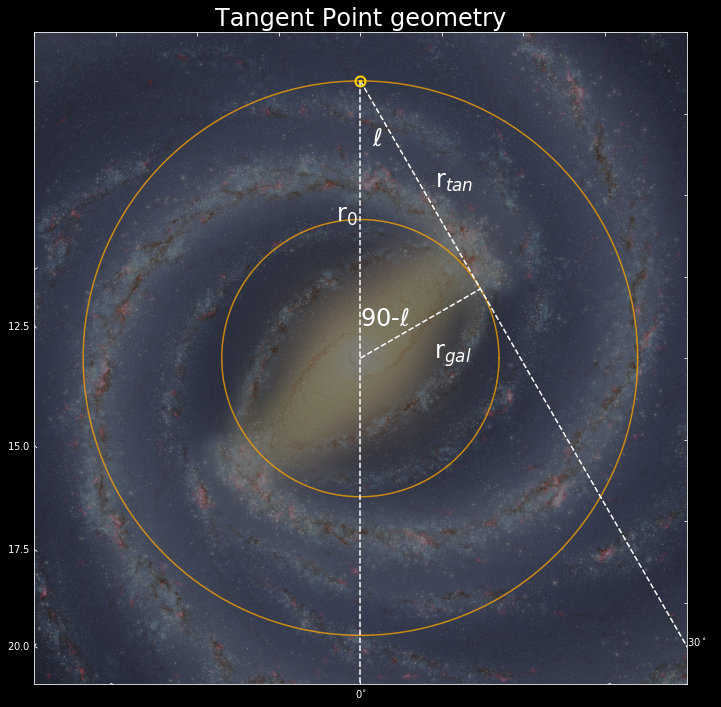

In [12]:
# don't run this cell unless you have the file mw_tangentpoint_geometry.png in your current directory
# (it will crash and then you won't have the diagram any more)
from IPython.display import Image
Image("mw_tangentpoint_geometry.png")

The tangent point geometry tells you what Galactocentric distance you're observing.

For example, for $\ell=30$, $r_0=8.5$ kpc, $r_{gal} = \sin(\ell) r_0 = 4.25$ kpc.

The velocity we observe is the circular velocity, $v_{orb}$, minus the sun's velocity projected in that direction.

However, the LSR is "at rest" with respect to the galaxy (to the best of our ability to measure it), so we've already subtracted that.

# Orbital Velocity to Mass: Overview

Recall that the orbital velocity of a body in a gravitational potential only depends on the mass interior to that body.

$$v_{orb} = \sqrt{\frac{G M}{R}}$$

If we can measure $v_{orb}$, and we know what $R$ we're observing, we can infer the contained mass, $M$.

$$M = \frac{R_{gal} v_{orb}^2}{G}$$

What mass do we infer?

In [13]:
# our longitude comes from the target we pointed at:
target_galactic.l

<Longitude 27.85023361 deg>

In [14]:
# it's in the midplane because b is about zero
# (if this number's not close to zero, you're not looking at the Galactic plane!)
target_galactic.b

<Latitude -0.02209999 deg>

# Galactic Longitude to Galactocentric Radius

What is $R_{gal}$?  $R_{gal} = \sin\ell \times r_0$:

In [15]:
# calculate rgal, the distance from the galactic center to the tangent point along our target line-of-sight
rgal = np.sin(target_galactic.l) * r0
rgal

<Quantity 3.97087709 kpc>

Our LSR velocity is the velocity we want to measure, so to get mass, we just put in:

$$ M = \frac{R_{gal} v^2}{G} $$

In [16]:
# we'll put the observed radial velocity into its own variable, but we calculated it already above
vlsr = lsrcoord.radial_velocity

# Orbital Velocity + Galactocentric Radius -> Mass

In [17]:
# calculate the mass
mass = rgal * vlsr**2 / constants.G
mass

<Quantity 1.75435195e+13 kg km2 kpc / m3>

That mass is in not-very-useful units.  Convert it to Solar Masses:

In [18]:
mass.to(u.M_sun)

<Quantity 2.72245907e+08 solMass>

So if we had done this observation, we would infer that the mass of the Galaxy within a radius of $r_{gal} = 4$ kpc is about $3\times10^8$ M$_\odot$.   Because the numbers above are made up, though, don't trust this measurement!

# Exercise step

Repeat the above for an observation with the following properties:


altitude = 58$^\circ$

azimuth = 220$^\circ$

observation time: October 6, 2020 at 20:44:35

observed velocity: 27 km/s


In [ ]:
# Step 1: Create your observer object
# (you can reuse the same observer)
observer2 = 

In [ ]:
# Step 2: Create the assigned "datetime" object
# Remember to localize it with the pytz localize tool, otherwise it will be in the wrong time zone!
obstime2 = 

In [ ]:
# Step 3: Create the target Alt/Az coordinate object
target_altaz2 = 

In [ ]:
# Step 4: convert the target altaz to galactic
target_galactic2 = 

In [ ]:
# Step 5: Create your topocentric velocity variable
observed_line_of_sight_velocity2 = 

In [ ]:
# Step 6: Convert from topocentric to barycentric
velocity_bary2 = 

In [ ]:
# Step 7: Convert from barycentric to LSR
# (you'll need to do the special steps noted above - you need "dummy" proper motion, distance)
vlsr2 = 

In [ ]:
# Step 8: Compute the Galactocentric radius you're observing
# (we are assuming that we're observing the tangent point along our specified line-of-sight)
rgal2 = 

In [ ]:
# Step 9: Compute the mass interior to this orbit
mass2 = 